**Predictive modeling including steps:**
1. Prepare Problem
 - Load libraries
 - Load dataset
2. Summarize Data
 - Descriptive statistics
 - Data visualizations
3. Prepare Data
 - Data Cleaning
 - Feature Selection
 - Data Transforms
4. Evaluate Algorithms
 - Split-out validation dataset
 - Test options and evaluation metric
 - Spot-Check Algorithms
 - Compare Algorithms
5. Improve Accuracy
 - Algorithm Tuning
 - Ensembles
6. Finalize Model
 - Predictions on validation dataset
 - Create standalone model on entire training dataset
 - Save model for later use

In [1]:
%matplotlib inline

In [2]:
from helper.load_data import load_data

## Prepare Problem

In [3]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import cross_validation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVR
from scipy.stats import skew

In [4]:
# config for show max number of output lines
pd.options.display.max_rows = 999
pd.options.display.max_columns = 100

In [5]:
seed = 7

In [31]:
Y_df, X_df = load_data(train=True, SEED=seed, scale=True,
              minmax=False,
              nointercept=True,
              engineering=False)

In [32]:
X_df.head()

,moSinceLast,moSinceFirst,moSinceLast:moSinceFirst,numDonations,volume
543,0.803193,-0.745678,-0.598923,-0.771938,-0.771938
326,0.803193,1.072006,0.861028,-0.074469,-0.074469
275,0.558346,0.700207,0.390957,0.099898,0.099898
101,-0.910739,-0.332568,0.302882,-0.248836,-0.248836
60,-0.665891,1.526427,-1.016434,2.017936,2.017936


In [33]:
X_df.shape

(576, 5)

In [34]:
X_test, IDs = load_data(train=False, SEED=seed, scale=True,
              minmax=False,
              nointercept=True,
              engineering=False)

In [35]:
X_test.shape

(200, 5)

In [36]:
X_test.head()

,moSinceLast,moSinceFirst,moSinceLast:moSinceFirst,numDonations,volume
0,-0.986184,0.659724,-0.650610,0.992653,0.992653
1,1.513816,0.100805,0.152600,0.174308,0.174308
2,-0.723027,-1.256570,0.908533,-0.807707,-0.807707
3,0.198026,0.100805,0.019962,0.828984,0.828984
4,-0.723027,-0.058886,0.042576,0.992653,0.992653


## Evaluate Algorithms

### Baseline

In [37]:
# Test options and evaluation metric
num_folds = 10
num_instances = len(X_train)
validation_size = 0.20
scoring = 'log_loss'
# scoring = 'accuracy'

In [38]:
X_train, X_validation, Y_train, Y_validation = cross_validation.train_test_split(X_df, Y_df,
    test_size=validation_size, random_state=seed)

In [39]:
# Spot-Check Algorithms
models = []
models.append(('LogisticRegression', LogisticRegression()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('SVC', SVC(probability=True)))

In [40]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold,
      scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LogisticRegression: -0.503302 (0.080202)
KNeighborsClassifier: -2.534732 (0.777671)
DecisionTreeClassifier: -7.837931 (2.027846)
GaussianNB: -0.769334 (0.312329)
SVC: -0.539003 (0.094723)


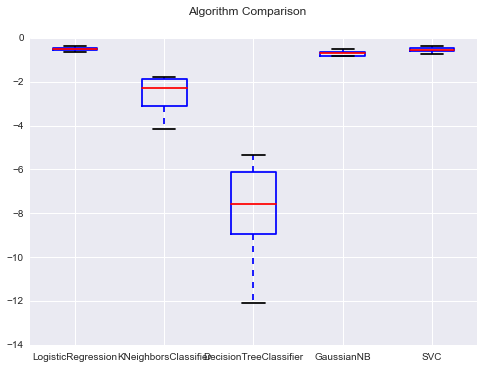

In [41]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We can see that LogisticRegression has best score. Let's turning

In [42]:
param_grid = dict(
    penalty=['l1', 'l2'],
    C=[0.1, 0.3, 0.5, 0.7, 1.0, 2.0]
)

model = LogisticRegression()
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

In [43]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.502602 using {'penalty': 'l1', 'C': 0.5}
-0.511390 (0.074071) with: {'penalty': 'l1', 'C': 0.1}
-0.504822 (0.069552) with: {'penalty': 'l2', 'C': 0.1}
-0.503423 (0.078166) with: {'penalty': 'l1', 'C': 0.3}
-0.502897 (0.076726) with: {'penalty': 'l2', 'C': 0.3}
-0.502602 (0.079205) with: {'penalty': 'l1', 'C': 0.5}
-0.503014 (0.078615) with: {'penalty': 'l2', 'C': 0.5}
-0.502668 (0.079863) with: {'penalty': 'l1', 'C': 0.7}
-0.503154 (0.079501) with: {'penalty': 'l2', 'C': 0.7}
-0.502899 (0.080416) with: {'penalty': 'l1', 'C': 1.0}
-0.503302 (0.080202) with: {'penalty': 'l2', 'C': 1.0}
-0.503298 (0.081146) with: {'penalty': 'l1', 'C': 2.0}
-0.503528 (0.081064) with: {'penalty': 'l2', 'C': 2.0}


## Improve Accuracy

### Ensembles

In [44]:
ensembles = []
ensembles.append(( 'RandomForestClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'AB' ,
    RandomForestClassifier())])))
ensembles.append(( 'ExtraTreesClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'GBM' ,
    ExtraTreesClassifier())])))
ensembles.append(( 'BaggingClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'RF' ,
    BaggingClassifier())])))
ensembles.append(( 'GradientBoostingClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'ET' ,
    GradientBoostingClassifier())])))
ensembles.append(( 'AdaBoostClassifier' , Pipeline([( 'Scaler' , StandardScaler()),( 'ET' ,
    AdaBoostClassifier())])))
results = []
names = []
for name, model in ensembles:
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    cv_results = cross_validation.cross_val_score(model, X_train, Y_train, cv=kfold,
      scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

RandomForestClassifier: -2.240248 (0.976048)
ExtraTreesClassifier: -3.589260 (1.491376)
BaggingClassifier: -2.794343 (1.610488)
GradientBoostingClassifier: -0.577579 (0.124137)
AdaBoostClassifier: -0.681928 (0.003384)


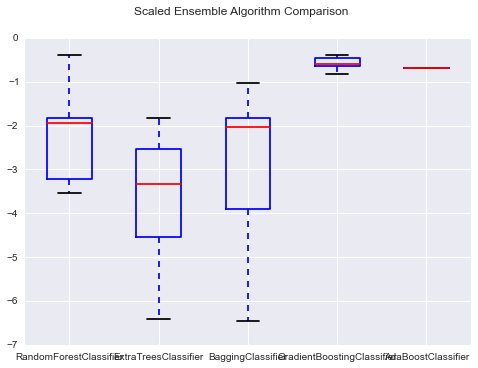

In [45]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle( 'Scaled Ensemble Algorithm Comparison' )
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

GradientBoostingClassifier has better result, let's turning.

The default number of boosting stages to perform (nestimators) is 100. This is a good candidate parameter of Gradient Boosting to tune. Often, the larger the number of boosting stages, the better the performance but the longer the training time. In this section we will look at tuning the number of stages for gradient boosting. Below we define a parameter grid n estimators values from 50 to 400 in increments of 50. Each setting is evaluated using 10-fold cross validation.

In [46]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingClassifier(random_state=seed)
kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

In [47]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
for params, mean_score, scores in grid_result.grid_scores_:
    print("%f (%f) with: %r" % (scores.mean(), scores.std(), params))

Best: -0.541565 using {'n_estimators': 50}
-0.541565 (0.105590) with: {'n_estimators': 50}
-0.578446 (0.125110) with: {'n_estimators': 100}
-0.618350 (0.148224) with: {'n_estimators': 150}
-0.664258 (0.171722) with: {'n_estimators': 200}
-0.707595 (0.194437) with: {'n_estimators': 250}
-0.741610 (0.211269) with: {'n_estimators': 300}
-0.781727 (0.225816) with: {'n_estimators': 350}
-0.830096 (0.241243) with: {'n_estimators': 400}


## Finalize Model

### Baseline

In [48]:
# prepare the model
model = LogisticRegression(penalty='l2', C=0.3)
model.fit(X_train, Y_train)

LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [49]:
# transform the validation dataset
predictions = model.predict(X_validation)
print(log_loss(Y_validation, predictions))

7.74144988162


### Ensembles

In [50]:
# prepare the model
ensembles_model = GradientBoostingClassifier(random_state=seed, n_estimators=50)
ensembles_model.fit(X_train, Y_train)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              random_state=7, subsample=1.0, verbose=0, warm_start=False)

In [51]:
# transform the validation dataset
predictions = ensembles_model.predict(X_validation)
print(log_loss(Y_validation, predictions))

6.84823323683


## Predict results

In [52]:
preds = ensembles_model.predict_proba(X_test)

In [53]:
preds = [x[1] for x in preds]

In [54]:
solution = pd.DataFrame({"": IDs, "Made Donation in March 2007": preds})
solution.to_csv("./results/02_machine_learning_v01.csv", index = False)

This solution has score 10.8536 on Drivendata (position 642/2022 = top 31%) on Dec. 16, 2016, 6:01 a.m.

This solution has score 0.5194 on Drivendata (position 642/2022 = top 31%) on Dec. 19, 2016, 4:24 a.m.